In [237]:
# Essencial Libraries
import pandas as pd
import os
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
from typing import Optional, Tuple, List, Union
import matplotlib.patches as mpatches
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
!pip install lightgbm
import lightgbm as lgb
!pip install optuna
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [149]:
# CCT Dublin color palette
COR_1 = "#00558C"  # deep blue (primary)
COR_2 = "#0099D8"  # light blue (accent)
COR_3 = "#78BE20"  # green (support)
COR_CINZA = "#A7A8AA"  # soft grey


def plot_bivariate_distribution(
    df: pd.DataFrame,
    analysis_variable: str,
    target_variable: str,
    spam_ratio: float,
    convert_str: Optional[bool] = True,
    sort_values: Optional[bool] = False,
    figsize: Optional[Tuple[int, int]] = (16, 4),
    bar_width: Optional[float] = 0.3,
    y_labelsize: Optional[int] = 10,
    yticks_labelsize: Optional[int] = 10,
    show_line_labels: Optional[bool] = True,
    show_bar_labels: Optional[bool] = False,
    label_fontsize: Optional[int] = 9,
    rotation: Optional[int] = 45,
    ha: Optional[str] = 'right',
    is_category_axes: Optional[bool] = False,
    custom_xticks: Optional[Union[None, List[str]]] = None,
    ncol: Optional[int] = 4,
    bbox_to_anchor: Optional[Tuple[float, float, float, float]] = (0, 1.08, 1., .1),
    leg_fontsize: Optional[int] = 10,
    title_fontsize: Optional[int] = 14,
    title_pad: Optional[int] = 40,
    xticks_labelsize: Optional[int] = 10,
    title: Optional[str] = None,  # Fix: Default to None
    label1: str = "Spam",
    label2: str = "Non-Spam"
) -> None:

    # Fix: Define title inside the function
    if title is None:
        title = f'Spam ratio variation by variable: {analysis_variable}'

    df_tmp = df[[analysis_variable, target_variable]].copy()
    df_tmp['quantity'] = 1

    if convert_str:
        df_tmp[analysis_variable] = df_tmp[analysis_variable].astype(str)

    df_tmp = df_tmp.groupby(analysis_variable)[['quantity', target_variable]].sum().reset_index()

    if sort_values:
        df_tmp.sort_values(by=['quantity'], ascending=False, inplace=True)
    else:
        df_tmp.sort_values(by=[analysis_variable], inplace=True)

    df_tmp['non_event_count'] = (df_tmp['quantity'] - df_tmp[target_variable]).astype(int)
    df_tmp['event_ratio'] = df_tmp[target_variable] / df_tmp['quantity']
    df_tmp['perc_distribution'] = 100 * df_tmp['quantity'] / df_tmp['quantity'].sum()
    df_tmp[target_variable] = df_tmp[target_variable].astype(int)

    fig, ax1 = plt.subplots(figsize=figsize)
    x_loc = np.arange(len(df_tmp))

    # Plot bar chart
    ax1.bar(x_loc - bar_width / 2, df_tmp[target_variable], width=bar_width, color=COR_1,
            linestyle='-', linewidth=4., alpha=0.6, label=label1)
    y1_b1_patch = mpatches.Patch(color=COR_1, label=label1, alpha=0.5)

    ax1.bar(x_loc + bar_width / 2, df_tmp['non_event_count'], width=bar_width, color=COR_2,
            linestyle='-', linewidth=4., alpha=0.6, label=label2)
    y1_b2_patch = mpatches.Patch(color=COR_2, label=label2, alpha=0.5)

    plt.ylabel('Transaction count', fontsize=y_labelsize)

    if show_bar_labels:
        for idx, bar in enumerate(ax1.patches):
            if idx < len(df_tmp):
                bar_value = bar.get_height()
                text_x = bar.get_x() + bar.get_width() / 2
                text_y = bar.get_y() + bar_value
                ax1.text(text_x, text_y, bar_value, ha='center', va='bottom', color='black', fontsize=label_fontsize)

    box = ax1.get_position()
    ax1.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])

    ax1.yaxis.grid(True, linestyle='--', which='major', color=COR_CINZA, alpha=.25)
    plt.gcf().autofmt_xdate(rotation=rotation, ha=ha)

    margin = (1 - bar_width) + bar_width / 2
    ax1.set_xlim(-margin, len(df_tmp) - 1 + margin)
    ax1.tick_params(axis='x', labelsize=xticks_labelsize)

    if is_category_axes:
        plt.xticks(df_tmp[analysis_variable])
    if custom_xticks:
        plt.xticks(np.arange(0, len(custom_xticks)).tolist(), custom_xticks)

    # Plot line chart for event ratio
    ax2 = ax1.twinx()
    y_values = round(100.00 * df_tmp['event_ratio'], 2)

    ax2.plot(
        df_tmp[analysis_variable], y_values,
        linestyle='-', marker='.',
        linewidth=1, color=COR_3
    )

    y2_patch = mpatches.Patch(color=COR_3, label="Event ratio")

    plt.ylabel("Event ratio [%]", fontsize=y_labelsize)
    ax2.set_ylim([0, round(y_values.max() * 1.1, 2)])

    if show_line_labels:
        props = dict(boxstyle='round', facecolor='white', alpha=0.5)
        for x, y in enumerate(y_values):
            ax2.text(x, y + (y*0.02), f'{round(y, 2)}%',
                     ha='center', va='bottom',
                     color=COR_3, weight='bold', bbox=props)

    # Plot fraud ratio reference line
    spam_ratio_fmt = round(100 * spam_ratio, 2)
    plt.axhline(spam_ratio_fmt, color=COR_CINZA, linestyle='--', alpha=0.7)
    base_patch = mpatches.Patch(color=COR_CINZA, label=f'Spam ratio: {spam_ratio_fmt}%')

    plt.legend(
        loc='upper center',
        ncol=ncol,
        bbox_to_anchor=bbox_to_anchor,
        borderaxespad=0.5,
        frameon=False,
        handles=[base_patch, y2_patch, y1_b1_patch, y1_b2_patch],
        fontsize=leg_fontsize
    )

    plt.title(
        title,
        fontsize=title_fontsize,
        weight='medium',
        pad=title_pad,
    )

    sns.despine(right=False)
    plt.show()

In [89]:
file_path = r'C:\Users\erikg\Documents\GitHub\ml-ca1-Erik2021374\spambase_v6.csv'
df = pd.read_csv(file_path)
df.head()

Unnamed: 0  word_freq_make word_freq_address  word_freq_all  word_freq_3d  \
0           0            0.00              0.64           0.64           0.0   
1           1            0.21              0.28           0.50           0.0   
2           2            0.06                 0           0.71           0.0   
3           3            0.00                 0           0.00           0.0   
4           4            0.00                 0           0.00           0.0   

  word_freq_our  word_freq_over word_freq_remove word_freq_internet  \
0          0.32            0.00                0                  0   
1          0.14            0.28             0.21               0.07   
2          1.23            0.19             0.19               0.12   
3          0.63            0.00             0.31               0.63   
4          0.63            0.00             0.31               0.63   

   word_freq_order  ...  char_freq_;  char_freq_(  char_freq_[  char_freq_!  \
0             0.00  ...         0.00        0.000          0.0        0.778   
1             0.00  ...         0.00        0.132          0.0        0.372   
2             0.64  ...         0.01        0.143          0.0        0.276   
3             0.31  ...         0.00        0.137          0.0        0.137   
4             0.31  ...         0.00        0.135          0.0        0.135   

  char_freq_$ char_freq_#  capital_run_length_average  \
0       0.000       0.000                       3.756   
1       0.180       0.048                       5.114   
2       0.184       0.010                       9.821   
3       0.000       0.000                       3.537   
4       0.000       0.000                       3.537   

   capital_run_length_longest  capital_run_length_total  is_spam  
0                          61                       278     True  
1                         101                      1028     True  
2                         485                      2259     True  
3                          40                       191     True  
4                          40                       191     True  

[5 rows x 59 columns]

In [90]:
# Drop the 'Unnamed: 0' column if it exists
df = df.drop(columns=["Unnamed: 0"], errors='ignore')

df = df.reset_index(drop=True)

In [143]:
#Setting variables of interest
spam = 'is_spam'
df[spam] = df[spam].astype(int)

#Tax of spam in the base
tax_spam = df[spam].mean()
event = df[spam].sum()
non_event = len(df) - event

print(f'There are {event} cases of spam and {non_event} of non events')
print(f'That value creates a tax basis of {tax_spam}')
print(f'So, one event is a spam for each {round(1/tax_spam)} analysed')

There are 1813 cases of spam and 2788 of non events
That value creates a tax basis of 0.39404477287546186
So, one event is a spam for each 3 analysed


In [92]:
print("Dataset Size:", df.shape)
print("\nData Types:")
print(df.dtypes)

Dataset Size: (4601, 58)

Data Types:
word_freq_make                float64
word_freq_address              object
word_freq_all                 float64
word_freq_3d                  float64
word_freq_our                  object
word_freq_over                float64
word_freq_remove               object
word_freq_internet             object
word_freq_order               float64
word_freq_mail                float64
word_freq_receive             float64
word_freq_will                float64
word_freq_people              float64
word_freq_report               object
word_freq_addresses            object
word_freq_free                float64
word_freq_business            float64
word_freq_email               float64
word_freq_you                 float64
word_freq_credit              float64
word_freq_your                float64
word_freq_font                float64
word_freq_000                  object
word_freq_money               float64
word_freq_hp                  float64
word_freq_hp

In [93]:
# Check for duplicated rows
num_duplicates = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {num_duplicates}")

# Check for NaN values per column
print("Number of NaN values per column:\n", df.isna().sum())

# Print total number of NaN values in the entire dataset
total_nans = df.isna().sum().sum()
print(f"\nTotal number of NaN values in dataset: {total_nans}")


Number of duplicate rows: 376
Number of NaN values per column:
 word_freq_make                  0
word_freq_address               0
word_freq_all                   6
word_freq_3d                    2
word_freq_our                   0
word_freq_over                  1
word_freq_remove                0
word_freq_internet             15
word_freq_order                 0
word_freq_mail                  0
word_freq_receive               0
word_freq_will                  0
word_freq_people                0
word_freq_report                0
word_freq_addresses             9
word_freq_free                  0
word_freq_business              0
word_freq_email                 0
word_freq_you                   0
word_freq_credit                0
word_freq_your                  0
word_freq_font                  0
word_freq_000                   0
word_freq_money                 0
word_freq_hp                    0
word_freq_hpl                   0
word_freq_george                0
word_freq_650    

In [94]:
# List of object-type columns to check for non-numeric values
object_cols = [
    "word_freq_address", "word_freq_our", "word_freq_remove", "word_freq_internet", 
    "word_freq_report", "word_freq_addresses", "word_freq_000", "word_freq_hpl", 
    "word_freq_labs"
]

# Check for non-numeric values in each object-type column
for col in object_cols:
    non_numeric_values = df[col][~df[col].astype(str).str.match(r'^-?\d+(\.\d+)?$', na=False)]
    if not non_numeric_values.empty:
        print(f"Column '{col}' contains non-numeric values:")
        print(non_numeric_values.unique(), "\n")


Column 'word_freq_address' contains non-numeric values:
['zero'] 

Column 'word_freq_our' contains non-numeric values:
['???'] 

Column 'word_freq_remove' contains non-numeric values:
['?'] 

Column 'word_freq_internet' contains non-numeric values:
[nan '?'] 

Column 'word_freq_report' contains non-numeric values:
['zero'] 

Column 'word_freq_addresses' contains non-numeric values:
[nan 'zero'] 

Column 'word_freq_000' contains non-numeric values:
['???'] 

Column 'word_freq_hpl' contains non-numeric values:
['none'] 

Column 'word_freq_labs' contains non-numeric values:
[nan 'no'] 



In [95]:
# Display percentage of missing values per column, only for columns with missing values
missing_values = (df.isnull().mean() * 100).loc[lambda x: x > 0].sort_values(ascending=False)
print("\nPercentage of missing values per column:")
print(missing_values)


Percentage of missing values per column:
word_freq_labs         5.433601
word_freq_table        0.869376
word_freq_internet     0.326016
word_freq_cs           0.304282
word_freq_addresses    0.195610
word_freq_all          0.130406
word_freq_direct       0.065203
word_freq_3d           0.043469
word_freq_over         0.021734
word_freq_meeting      0.021734
dtype: float64


In [96]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
print(f"Categorical Variables: {categorical_cols}\n")
print(f"Numerical Variables: {numerical_cols}\n")

Categorical Variables: ['word_freq_address', 'word_freq_our', 'word_freq_remove', 'word_freq_internet', 'word_freq_report', 'word_freq_addresses', 'word_freq_000', 'word_freq_hpl', 'word_freq_labs']

Numerical Variables: ['word_freq_make', 'word_freq_all', 'word_freq_3d', 'word_freq_over', 'word_freq_order', 'word_freq_mail', 'word_freq_receive', 'word_freq_will', 'word_freq_people', 'word_freq_free', 'word_freq_business', 'word_freq_email', 'word_freq_you', 'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_money', 'word_freq_hp', 'word_freq_george', 'word_freq_650', 'word_freq_lab', 'word_freq_telnet', 'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85', 'word_freq_technology', 'word_freq_1999', 'word_freq_parts', 'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting', 'word_freq_original', 'word_freq_project', 'word_freq_re', 'word_freq_edu', 'word_freq_table', 'word_freq_conference', 'char_freq_;', 'char_freq_(', 'char_freq_[', 'char_

In [97]:
# Frequency of unique items in categorical variables
if categorical_cols:
    for col in categorical_cols:
        print(f"\nValue Counts for {col}:\n{df[col].value_counts()}\n")
else:
    print("No categorical variables found.\n")


Value Counts for word_freq_address:
word_freq_address
0        3702
14.28      35
0.08       27
0.1        24
0.17       24
         ... 
1.2         1
0.96        1
2.4         1
2.46        1
2.01        1
Name: count, Length: 172, dtype: int64


Value Counts for word_freq_our:
word_freq_our
0       2852
0.36      28
0.32      26
0.19      24
0.8       24
        ... 
2.03       1
1.72       1
2.9        1
1.9        1
1.96       1
Name: count, Length: 256, dtype: int64


Value Counts for word_freq_remove:
word_freq_remove
0       3793
0.08      30
0.05      21
0.5       19
0.32      19
        ... 
0.85       1
0.75       1
2.35       1
2.46       1
0.88       1
Name: count, Length: 174, dtype: int64


Value Counts for word_freq_internet:
word_freq_internet
0       3761
0.05      24
0.18      21
0.32      20
0.1       20
        ... 
0.68       1
1.65       1
2.94       1
0.66       1
?          1
Name: count, Length: 171, dtype: int64


Value Counts for word_freq_report:
word_freq

In [66]:
# Basic statistics for numerical variables
print(f"Basic Statistics for Numerical Variables:\n{df[numerical_cols].describe()}\n")

Basic Statistics for Numerical Variables:
       word_freq_make  word_freq_all  word_freq_3d  word_freq_over  \
count     4601.000000    4595.000000   4599.000000     4600.000000   
mean         0.104553       0.281023      0.065453        0.095922   
std          0.305358       0.504370      1.395454        0.273850   
min          0.000000       0.000000      0.000000        0.000000   
25%          0.000000       0.000000      0.000000        0.000000   
50%          0.000000       0.000000      0.000000        0.000000   
75%          0.000000       0.420000      0.000000        0.000000   
max          4.540000       5.100000     42.810000        5.880000   

       word_freq_order  word_freq_mail  word_freq_receive  word_freq_will  \
count      4601.000000     4601.000000        4601.000000     4601.000000   
mean          0.090067        0.239413           0.059824        0.541702   
std           0.278616        0.644755           0.201545        0.861698   
min           0.000

In [67]:
for col in categorical_cols:
    print(f"{col}: {df[col].unique()[:10]}")  # Show first unique values

word_freq_address: ['0.64' '0.28' '0' '0.12' '0.69' '0.42' '0.63' '0.07' '0.68' '0.48']
word_freq_our: ['0.32' '0.14' '1.23' '0.63' '1.85' '1.92' '1.88' '0.61' '0.19' '0']
word_freq_remove: ['0' '0.21' '0.19' '0.31' '0.3' '0.38' '0.96' '0.25' '0.9' '0.42']
word_freq_internet: ['0' '0.07' '0.12' '0.63' '1.85' '1.88' '0.35' nan '0.02' '2.45']
word_freq_report: ['0' '0.21' '0.06' '1.23' '0.23' '0.3' '0.37' '1.26' '1.27' '4.76']
word_freq_addresses: ['0' '0.14' '1.75' '0.12' '0.18' '1.27' nan '0.3' '0.26' '0.03']
word_freq_000: ['0' '0.43' '1.16' '0.19' '0.35' '0.7' '0.31' '0.05' '0.48' '0.3']
word_freq_hpl: ['0' '0.34' '0.05' '1.49' '0.21' '0.39' '0.1' '0.44' '0.51' '0.04']
word_freq_labs: [nan '0.39' '0' '0.06' '0.66' '2.24' '0.24' '3.38' '0.97' '0.86']


In [82]:
# Identify categorical variables (only object types)
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Identify categorical variables that can be transformed directly (10 or fewer unique values)
transformable_categorical = [col for col in categorical_cols if df[col].nunique() <= 10]

# Print the results
print(f"Categorical Variables Suitable for Direct Transformation: {transformable_categorical}\n")


Categorical Variables Suitable for Direct Transformation: []



In [98]:
# Define a function to clean and convert
def safe_convert(val):
    if isinstance(val, str):
        val = val.lower().strip()  # Normalize case and strip spaces
        if val in ["zero"]:  # Replace known non-numeric values
            return 0.0  # Or use np.nan if you prefer missing values
        if val in ["?", "none"]:
            return np.nan  # Use np.nan instead of NaN
    
    try:
        return float(val)  # Convert valid numbers
    except ValueError:
        return np.nan  # Handle unexpected cases

# Convert boolean to integer
df["is_spam"] = df["is_spam"].astype(int)

# Apply the conversion to all object columns
df[df.select_dtypes(include='object').columns] = df.select_dtypes(include='object').applymap(safe_convert)

# Check for NaN values per column
print("Number of NaN values per column:\n", df.isna().sum())

# Print total number of NaN values in the dataset
total_nans = df.isna().sum().sum()
print(f"\nTotal number of NaN values in dataset: {total_nans}")


Number of NaN values per column:
 word_freq_make                  0
word_freq_address               0
word_freq_all                   6
word_freq_3d                    2
word_freq_our                   1
word_freq_over                  1
word_freq_remove                1
word_freq_internet             16
word_freq_order                 0
word_freq_mail                  0
word_freq_receive               0
word_freq_will                  0
word_freq_people                0
word_freq_report                0
word_freq_addresses             9
word_freq_free                  0
word_freq_business              0
word_freq_email                 0
word_freq_you                   0
word_freq_credit                0
word_freq_your                  0
word_freq_font                  0
word_freq_000                   1
word_freq_money                 0
word_freq_hp                    0
word_freq_hpl                   1
word_freq_george                0
word_freq_650                   0
word_freq_lab 

In [100]:
# Identify columns that should be numerical
expected_numerical_cols = df.select_dtypes(exclude=['object']).columns.tolist()

# Check for non-numeric values in columns expected to be numerical
for col in df.columns:
    non_numeric_values = df[col][~df[col].astype(str).str.replace('.', '', 1).str.isnumeric()]
    
    if not non_numeric_values.empty:
        print(f"Column: {col}")
        print(f"Non-Numeric Values Found: {non_numeric_values.unique()}\n")

Column: word_freq_all
Non-Numeric Values Found: [nan]

Column: word_freq_3d
Non-Numeric Values Found: [nan]

Column: word_freq_our
Non-Numeric Values Found: [nan]

Column: word_freq_over
Non-Numeric Values Found: [nan]

Column: word_freq_remove
Non-Numeric Values Found: [nan]

Column: word_freq_internet
Non-Numeric Values Found: [nan]

Column: word_freq_addresses
Non-Numeric Values Found: [nan]

Column: word_freq_000
Non-Numeric Values Found: [nan]

Column: word_freq_hpl
Non-Numeric Values Found: [nan]

Column: word_freq_labs
Non-Numeric Values Found: [nan]

Column: word_freq_direct
Non-Numeric Values Found: [nan]

Column: word_freq_cs
Non-Numeric Values Found: [nan]

Column: word_freq_meeting
Non-Numeric Values Found: [nan]

Column: word_freq_table
Non-Numeric Values Found: [nan]



In [71]:
print(df) # hcecking if all the columns

      word_freq_make  word_freq_address  word_freq_all  word_freq_3d  \
0               0.00               0.64           0.64           0.0   
1               0.21               0.28           0.50           0.0   
2               0.06               0.00           0.71           0.0   
3               0.00               0.00           0.00           0.0   
4               0.00               0.00           0.00           0.0   
...              ...                ...            ...           ...   
4596            0.31               0.00           0.62           0.0   
4597            0.00               0.00           0.00           0.0   
4598            0.30               0.00           0.30           0.0   
4599            0.96               0.00           0.00           0.0   
4600            0.00               0.00           0.65           0.0   

      word_freq_our  word_freq_over  word_freq_remove  word_freq_internet  \
0              0.32            0.00              0.00     

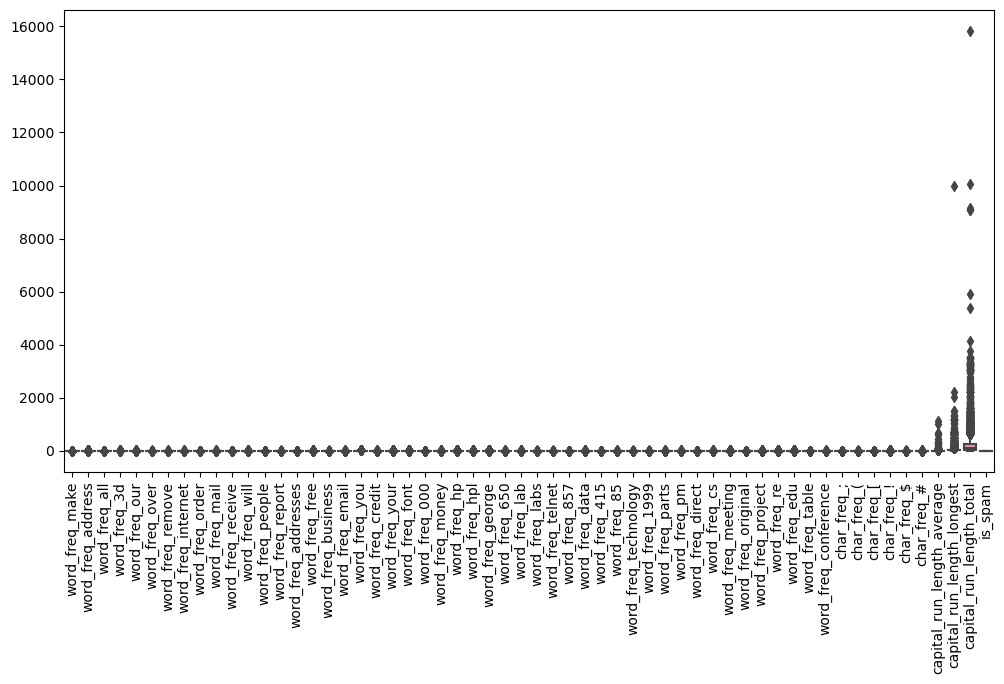

In [72]:
# Plot boxplots to visualize outliers
plt.figure(figsize=(12,6))
sns.boxplot(data=df)
plt.xticks(rotation=90)  # Rotate column names if needed
plt.show()

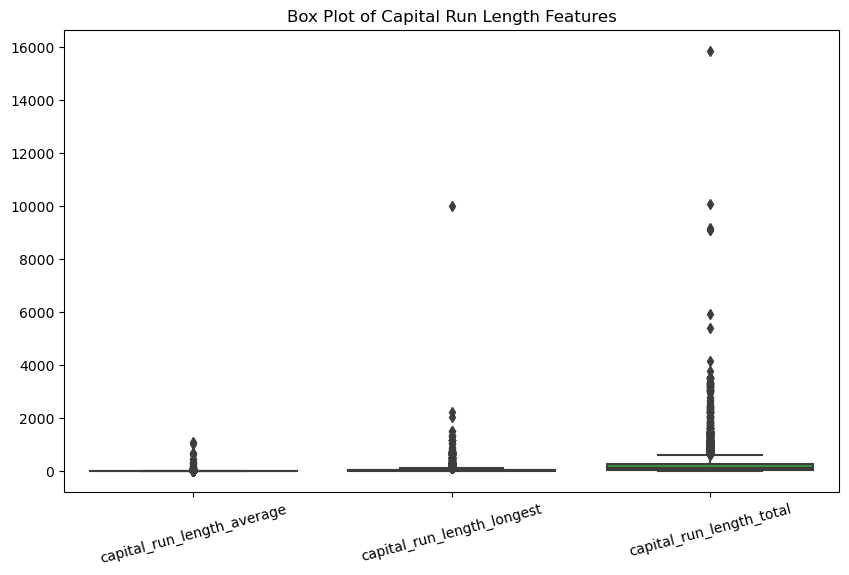

In [77]:
# Define the columns of interest
columns_to_plot = ["capital_run_length_average", "capital_run_length_longest", "capital_run_length_total"]

# Set figure size
plt.figure(figsize=(10, 6))

# Create box plot
sns.boxplot(data=df[columns_to_plot])

# Add title
plt.title("Box Plot of Capital Run Length Features")

# Rotate x-axis labels if needed
plt.xticks(rotation=15)

# Show plot
plt.show()

In [80]:
# Calculate Z-Scores
z_scores = np.abs(stats.zscore(df))

# Identify outliers (Z > 3)
outliers_z = z_scores > 3

# Count how many outliers exist per column
outliers_z_count = pd.Series(outliers_z.sum(axis=0), index=df.columns)

# Show only columns with outliers, sorted in descending order
print(outliers_z_count[outliers_z_count > 0].sort_values(ascending=False))

word_freq_george              123
word_freq_order               113
word_freq_original            107
word_freq_650                 107
word_freq_report              106
word_freq_email               106
word_freq_1999                105
word_freq_will                102
word_freq_receive             100
word_freq_business             97
word_freq_make                 90
word_freq_people               89
word_freq_your                 87
word_freq_hp                   86
capital_run_length_total       86
word_freq_85                   82
word_freq_data                 77
word_freq_technology           77
word_freq_credit               76
word_freq_mail                 74
word_freq_edu                  74
word_freq_free                 69
word_freq_pm                   69
capital_run_length_longest     68
word_freq_re                   64
word_freq_lab                  64
char_freq_$                    62
word_freq_telnet               61
word_freq_you                  60
word_freq_font

# Outlier Detection Using IQR Method



In [81]:
# Calcular Q1, Q3 e IQR para cada coluna numérica
df.columns = df.select_dtypes(include=[np.number]).columns
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Determinar os limites inferior e superior
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificar os outliers
outliers = ((df< lower_bound) | (df > upper_bound))

# Exibir as colunas e quantidades de outliers detectados
outliers_count = outliers.sum()
print(outliers_count[outliers_count > 0].sort_values(ascending=False))

word_freq_hp                  1090
word_freq_make                1053
word_freq_email               1038
word_freq_re                  1001
word_freq_over                 999
word_freq_business             963
word_freq_free                 957
word_freq_address              898
word_freq_mail                 852
word_freq_people               852
word_freq_1999                 829
word_freq_internet             824
word_freq_hpl                  811
char_freq_$                    811
word_freq_remove               807
char_freq_;                    790
word_freq_george               780
word_freq_order                773
char_freq_#                    750
word_freq_money                735
word_freq_receive              709
word_freq_000                  679
word_freq_technology           599
capital_run_length_total       550
char_freq_[                    529
word_freq_edu                  517
word_freq_our                  501
word_freq_85                   485
word_freq_labs      

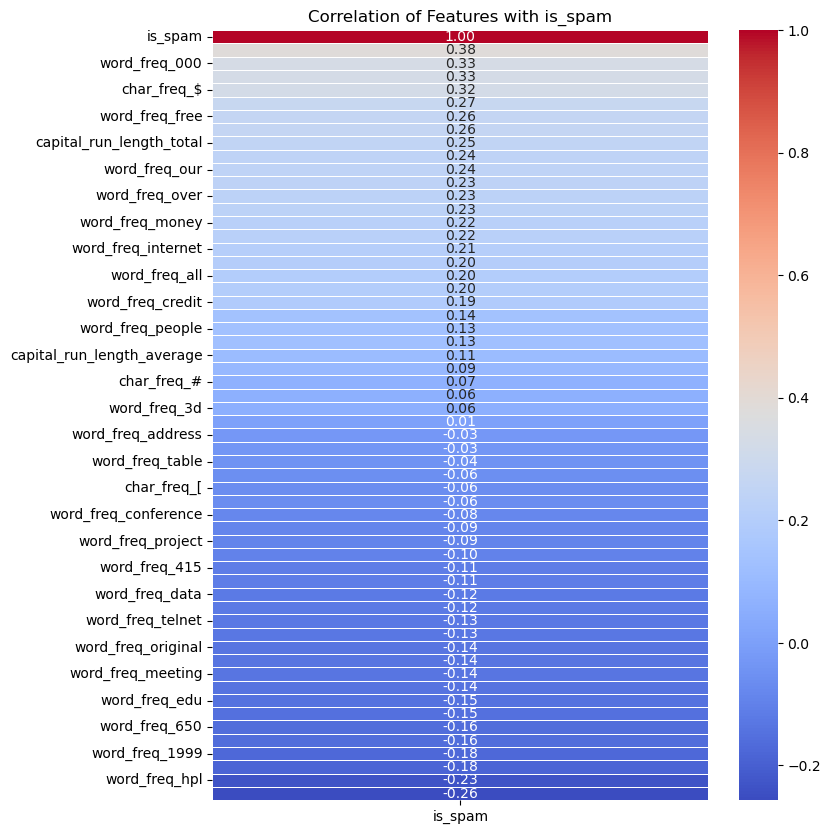

In [76]:
# Compute correlation matrix
correlation_matrix = df.corr()

# Filter correlations only with 'is_spam'
corr_with_target = correlation_matrix[["is_spam"]].sort_values(by="is_spam", ascending=False)

# Plot heatmap
plt.figure(figsize=(8, 10))  # Adjust figure size
sns.heatmap(corr_with_target, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".2f")

# Title
plt.title("Correlation of Features with is_spam")
plt.show()

# Rodar WoE, IV e IM

In [212]:
# Function to calculate WoE and IV
def calculate_woe_iv(df, feature, target):
    df = df[[feature, target]].copy()
    df["bin"] = pd.qcut(df[feature], q=10, duplicates='drop')  # Binning (adjust bins if needed)
    
    grouped = df.groupby("bin")[target].agg(["count", "sum"])  # Group by bins
    grouped["non_events"] = grouped["count"] - grouped["sum"]  # Count of non-events
    grouped["event_rate"] = grouped["sum"] / grouped["count"]  # Event rate
    
    # Avoid division by zero
    grouped["woe"] = np.log((grouped["sum"] / grouped["sum"].sum()) / (grouped["non_events"] / grouped["non_events"].sum()))
    grouped["woe"] = grouped["woe"].replace({np.inf: 0, -np.inf: 0})  # Replace infinite values
    
    # Calculate IV
    grouped["iv"] = (grouped["woe"] * ((grouped["sum"] / grouped["sum"].sum()) - (grouped["non_events"] / grouped["non_events"].sum())))
    iv = grouped["iv"].sum()
    
    return grouped[["woe", "iv"]], iv

# Apply WoE & IV calculation for all numeric features
target_var = "is_spam"  # Defining target variable
iv_values = {}

for col in df.select_dtypes(include=np.number).columns:
    if col != target_var:
        _, iv = calculate_woe_iv(df, col, target_var)
        iv_values[col] = iv

# Convert IV results to DataFrame and sort
iv_df = pd.DataFrame(list(iv_values.items()), columns=["Feature", "IV"]).sort_values(by="IV", ascending=False)
print("\nInformation Value (IV) Ranking:\n", iv_df)



Information Value (IV) Ranking:
                        Feature        IV
52                 char_freq_$  1.687796
51                 char_freq_!  1.579852
55  capital_run_length_longest  1.470283
54  capital_run_length_average  1.265119
24                word_freq_hp  1.264887
20              word_freq_your  1.226585
56    capital_run_length_total  1.112353
26            word_freq_george  0.964484
15              word_freq_free  0.955496
22               word_freq_000  0.954710
6             word_freq_remove  0.862373
18               word_freq_you  0.718752
23             word_freq_money  0.705876
4                word_freq_our  0.609606
25               word_freq_hpl  0.571440
2                word_freq_all  0.531496
16          word_freq_business  0.512472
29              word_freq_labs  0.446129
5               word_freq_over  0.434613
10           word_freq_receive  0.410206
17             word_freq_email  0.352920
34                word_freq_85  0.349835
45               word_f

In [209]:
# Iterate over each column in the DataFrame 'df' that has a numeric data type
for col in df.select_dtypes(include=['number']).columns:
    # Fill missing values (NaN) in the current column 'col' with the median of that column
    # The 'inplace=True' argument modifies the DataFrame 'df' directly without creating a copy
    df[col].fillna(df[col].median(), inplace=True)
    
print(df.isnull().sum().sum())  # Should be 0 now


0


In [213]:
# Calculate Mutual Information
X = df.drop(columns=[target_var])  # Features
y = df[target_var]  # Target variable

# Calculate the mutual information scores between each feature in X and the target variable y
mi_scores = mutual_info_classif(X, y, discrete_features=False, random_state=42)

# Create a DataFrame to store the feature names and their corresponding mutual information scores
mi_df = pd.DataFrame({"Feature": X.columns, "Mutual Information": mi_scores}).sort_values(by="Mutual Information", ascending=False)
print("\nMutual Information Ranking:\n", mi_df)

TypeError: float() argument must be a string or a real number, not 'pandas._libs.interval.Interval'

1. char_freq_!

    IV: 1.579852
    MI: 0.210863
    
2. capital_run_length_longest

    IV: 1.470283
    MI: 0.201803

3. char_freq_$

    IV: 1.687796
    MI: 0.179903

4. capital_run_length_average

    IV: 1.265119
    MI: 0.172678

5. word_freq_your

    IV: 1.226585
    MI: 0.171881
    
6. word_freq_remove

    IV: 0.863035
    MI: 0.151288
    
# Key Findings:

Variables with Strong Positive Correlation with is_spam:

word_freq_free: 0.26
word_freq_your: 0.30
word_freq_money: 0.22
Variables with Moderate Positive Correlation:

capital_run_length_average: 0.27
capital_run_length_total: 0.24
word_freq_business: 0.20

## Heat Maps

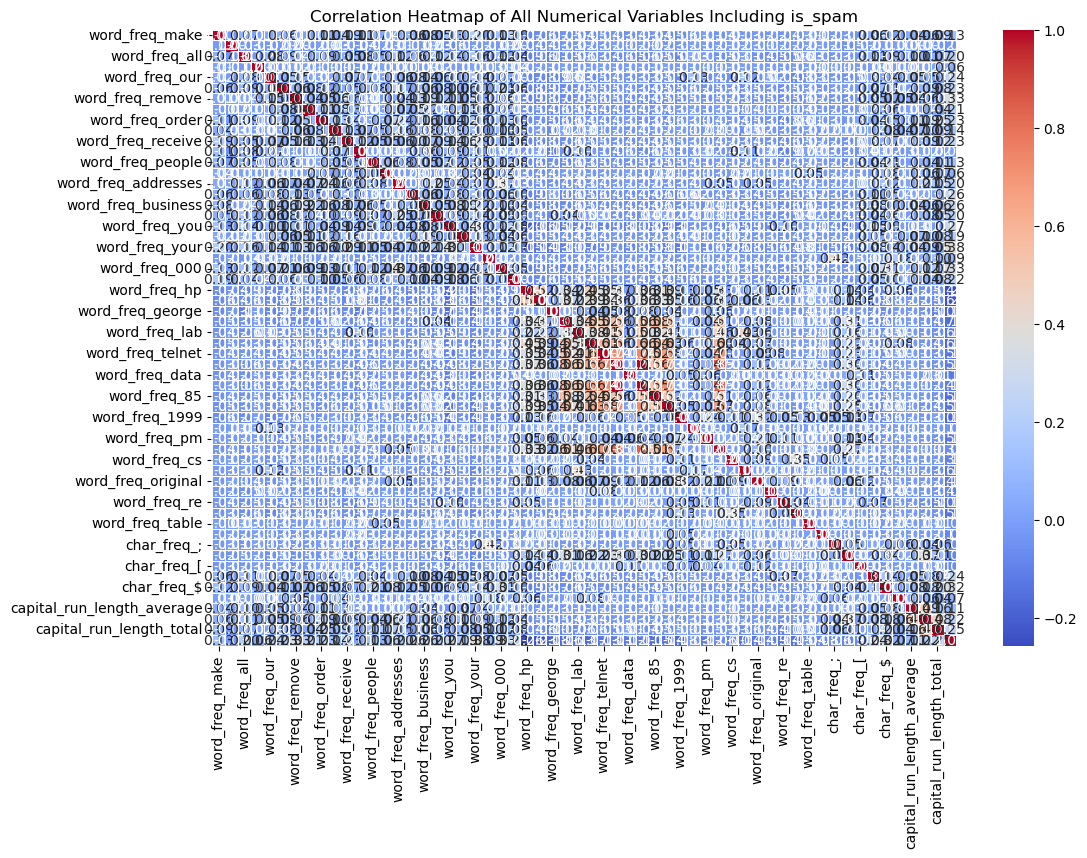

In [113]:
# Ensure 'is_spam' is included
df['is_spam'] = df['is_spam'].astype(int)  # Ensure it's binary (0,1)

# Select all numerical variables + 'is_spam'
numerical_cols = df.select_dtypes(include=['number']).columns.tolist()

# Generate heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of All Numerical Variables Including is_spam")
plt.show()

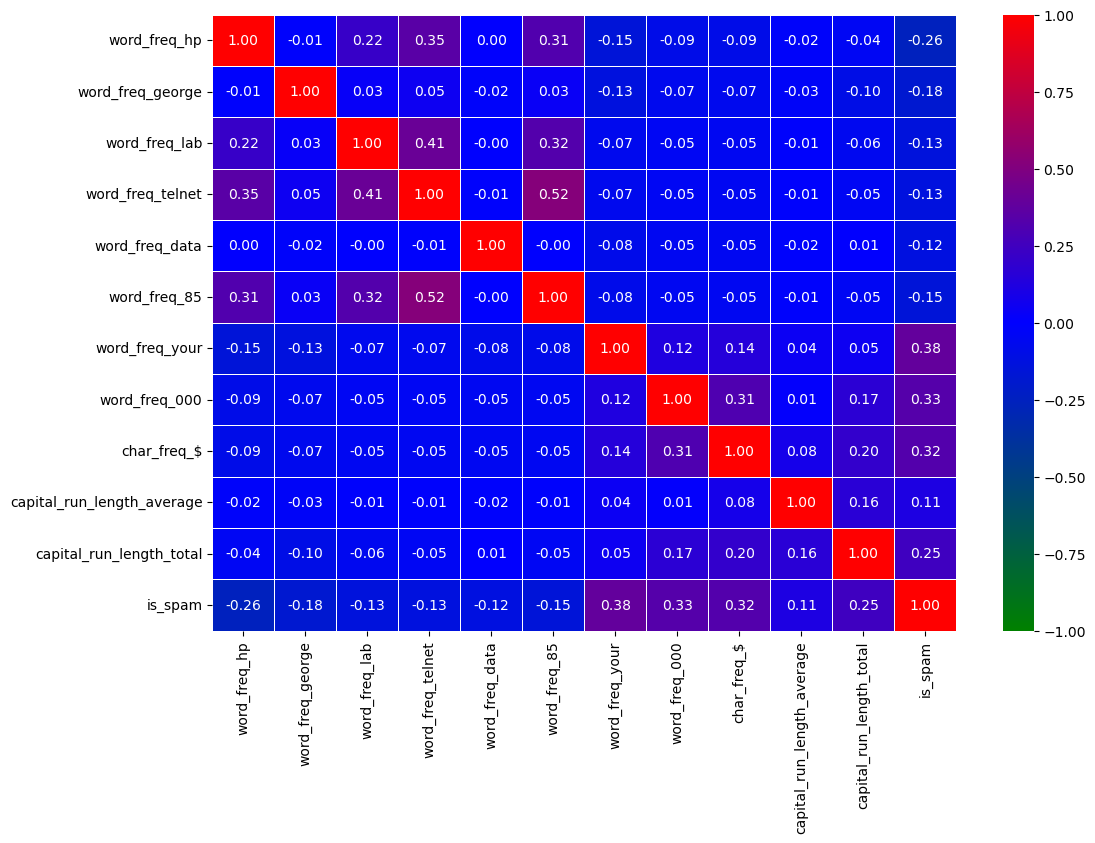

In [195]:
# Ensure 'is_spam' is numeric
df['is_spam'] = df['is_spam'].astype(int)

# Define custom colormap
custom_cmap = LinearSegmentedColormap.from_list('custom', ['green', 'blue', 'red'], N=256)

# Selected numerical variables + target variable
selected_vars = [
    "word_freq_hp", "word_freq_george", "word_freq_lab", "word_freq_telnet", 
    "word_freq_data", "word_freq_85", "word_freq_your", "word_freq_000", 
    "char_freq_$", "capital_run_length_average", "capital_run_length_total", "is_spam"
]

# Compute correlation matrix
correlation_matrix = df[selected_vars].corr()

# Normalize correlation values to fit into colormap
bounds = [-1.5, -0.5, 0.5, 1.5]
norm = plt.cm.colors.BoundaryNorm(bounds, custom_cmap.N)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap=custom_cmap, linewidths=0.5, vmin=-1, vmax=1)

plt.show()

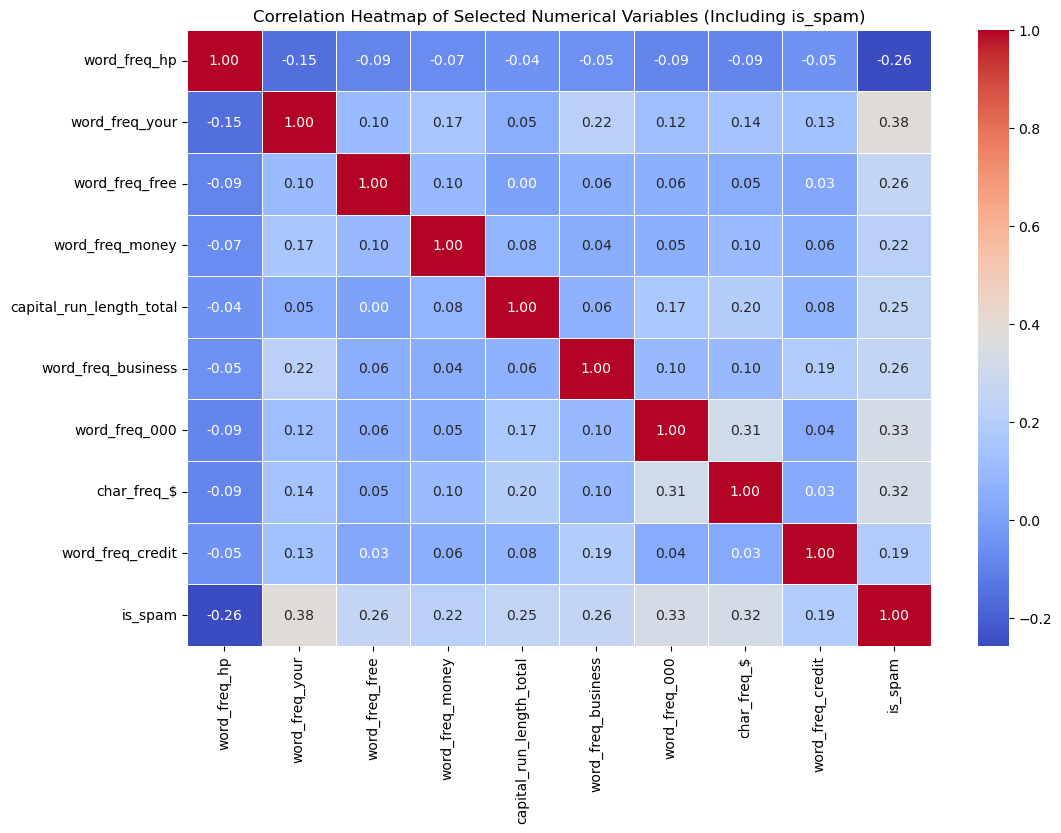

In [134]:
# Ensure 'is_spam' is numeric
df['is_spam'] = df['is_spam'].astype(int)

# Selected numerical variables + target variable
selected_vars = ["word_freq_hp", "word_freq_your", "word_freq_free", "word_freq_money", 
                 "capital_run_length_total", "word_freq_business","word_freq_000", "char_freq_$", "word_freq_credit", 
                 "is_spam"
]

# Compute correlation matrix
correlation_matrix = df[selected_vars].corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)

# Title
plt.title("Correlation Heatmap of Selected Numerical Variables (Including is_spam)")
plt.show()

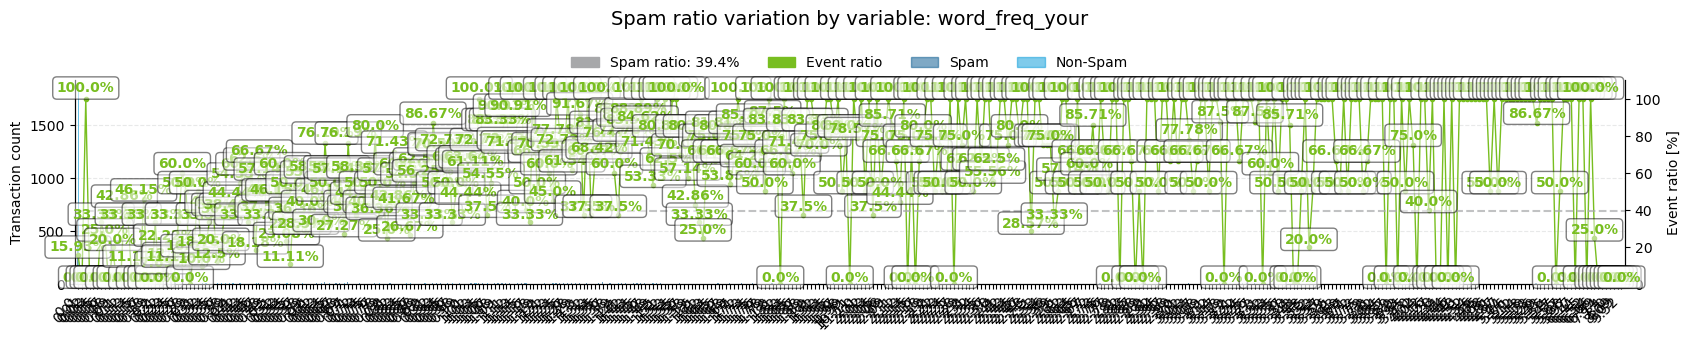

In [150]:
# Plotting the bivariate distribution
plot_bivariate_distribution(df=df, 
                            target_variable=spam, 
                            spam_ratio=tax_spam,
                            analysis_variable='word_freq_your',
                            sort_values=False, #to ensure the bins are in order 
                            figsize=(20, 3),
                            #custom_xticks=custom_labels
                            )

In [152]:
num_bins = 5  # 5 bins to represent quartiles, can be changed to better interpret the data
df["word_freq_your_bin"] = pd.qcut(df['word_freq_your'], q=num_bins, duplicates='drop')

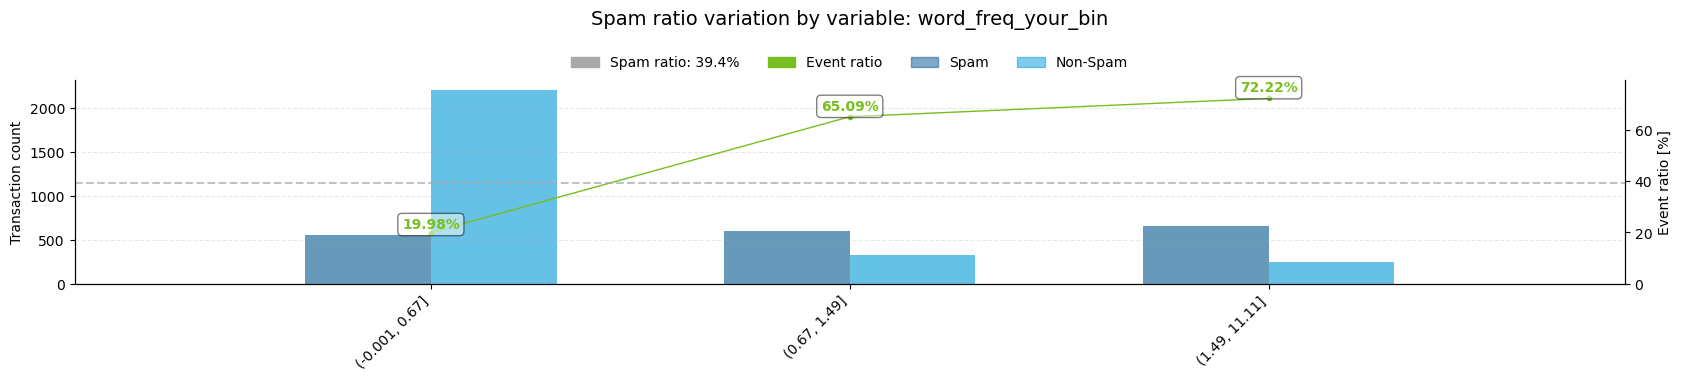

In [153]:
# Plotting the bivariate distribution
plot_bivariate_distribution(df=df, 
                            target_variable=spam, 
                            spam_ratio=tax_spam,
                            analysis_variable='word_freq_your_bin',
                            sort_values=False, #to ensure the bins are in order 
                            figsize=(20, 3),
                            #custom_xticks=custom_labels
                            )

In [154]:
num_bins = 5  # 5 bins to represent quartiles, can be changed to better interpret the data
df["word_freq_000_bin"] = pd.qcut(df['word_freq_000'], q=num_bins, duplicates='drop')

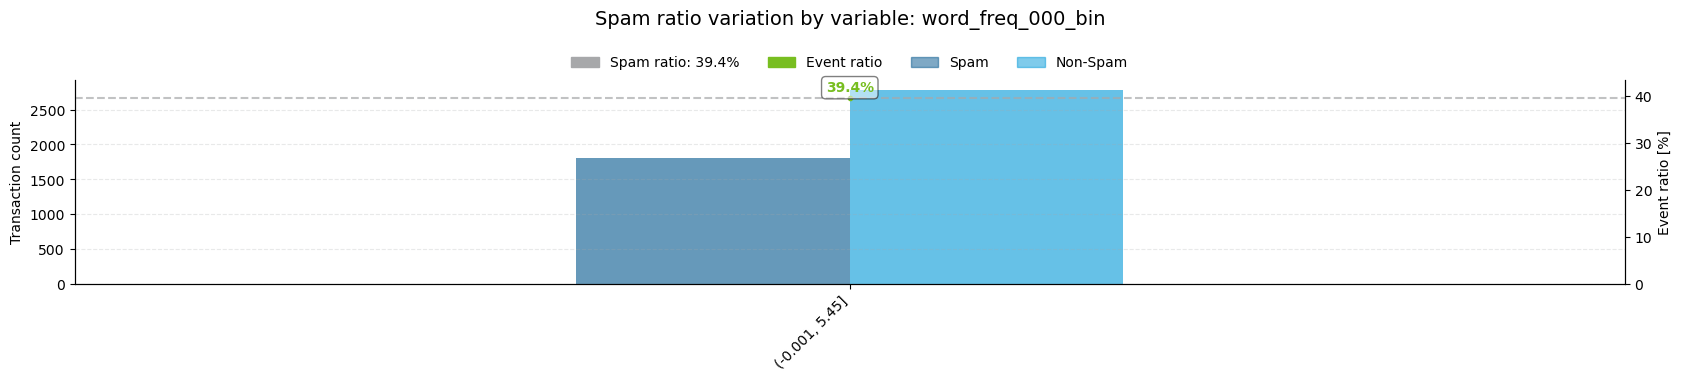

In [155]:
# Plotting the bivariate distribution
plot_bivariate_distribution(df=df, 
                            target_variable=spam, 
                            spam_ratio=tax_spam,
                            analysis_variable='word_freq_000_bin',
                            sort_values=False, #to ensure the bins are in order 
                            figsize=(20, 3),
                            #custom_xticks=custom_labels
                            )

In [159]:
num_bins = 5  # 5 bins to represent quartiles, can be changed to better interpret the data
df["word_freq_credit_bin"] = pd.qcut(df['word_freq_credit'], q=num_bins, duplicates='drop')

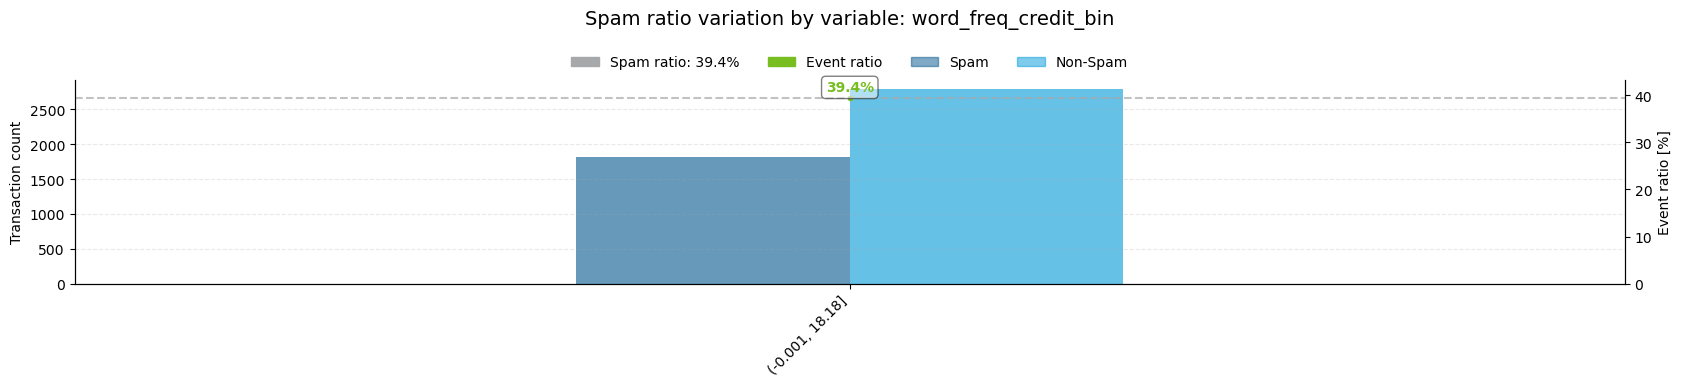

In [160]:
# Plotting the bivariate distribution
plot_bivariate_distribution(df=df, 
                            target_variable=spam, 
                            spam_ratio=tax_spam,
                            analysis_variable='word_freq_credit_bin',
                            sort_values=False, #to ensure the bins are in order 
                            figsize=(20, 3),
                            #custom_xticks=custom_labels
                            )

In [164]:
num_bins = 5  # 5 bins to represent quartiles, can be changed to better interpret the data
df["word_freq_money_bin"] = pd.qcut(df['word_freq_money'], q=num_bins, duplicates='drop')

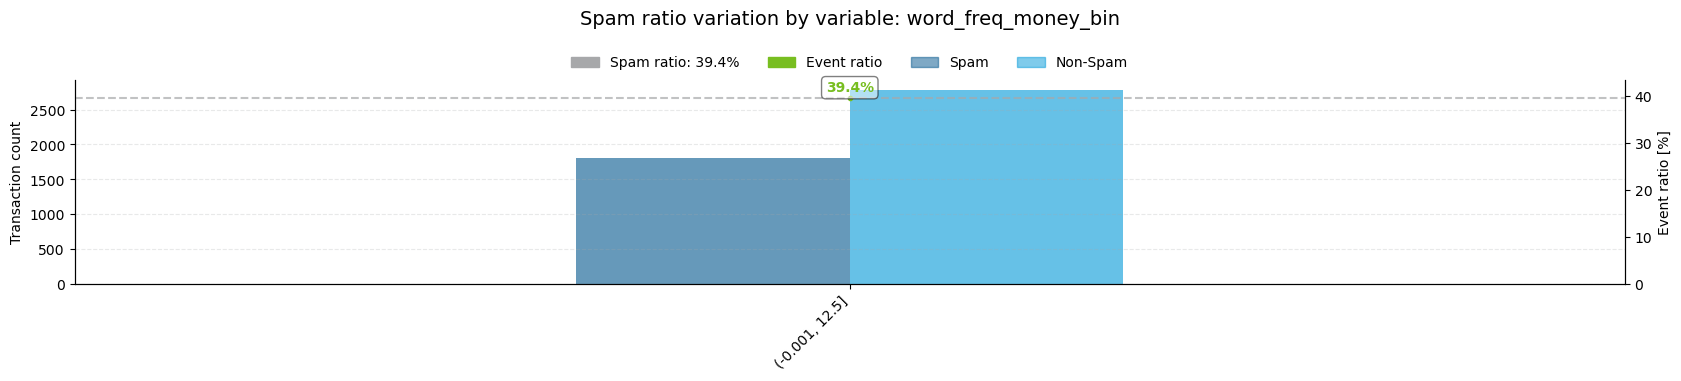

In [165]:
# Plotting the bivariate distribution
plot_bivariate_distribution(df=df, 
                            target_variable=spam, 
                            spam_ratio=tax_spam,
                            analysis_variable='word_freq_money_bin',
                            sort_values=False, #to ensure the bins are in order 
                            figsize=(20, 3),
                            #custom_xticks=custom_labels
                            )

In [166]:
num_bins = 5  # 5 bins to represent quartiles, can be changed to better interpret the data
df["word_freq_business_bin"] = pd.qcut(df['word_freq_business'], q=num_bins, duplicates='drop')

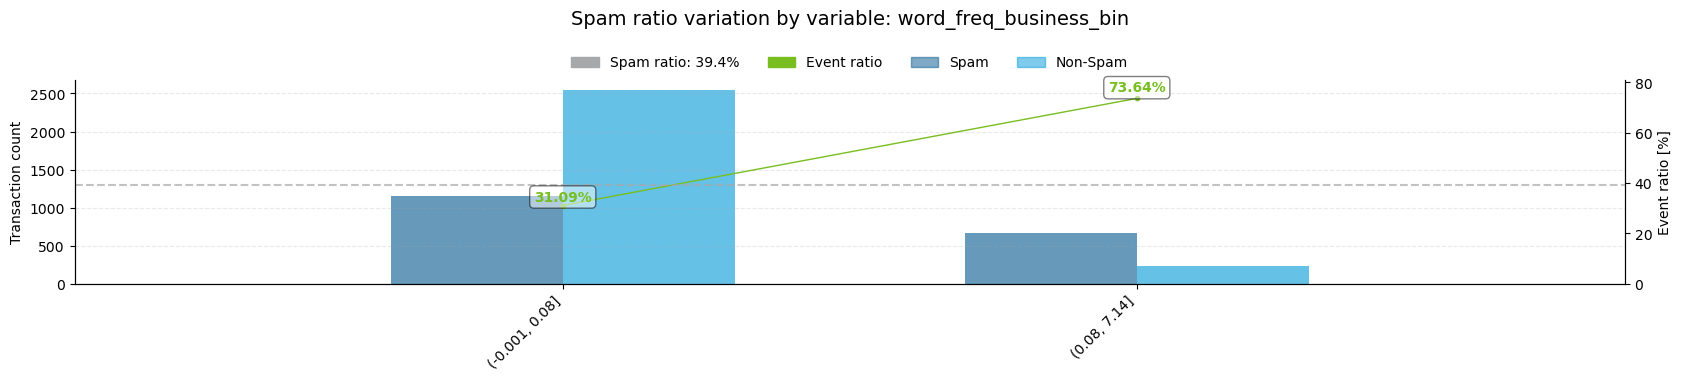

In [167]:
# Plotting the bivariate distribution
plot_bivariate_distribution(df=df, 
                            target_variable=spam, 
                            spam_ratio=tax_spam,
                            analysis_variable='word_freq_business_bin',
                            sort_values=False, #to ensure the bins are in order 
                            figsize=(20, 3),
                            #custom_xticks=custom_labels
                            )

In [187]:
num_bins = 10  # 5 bins to represent quartiles, can be changed to better interpret the data
df["capital_run_length_total_bin"] = pd.qcut(df['capital_run_length_total'], q=num_bins, duplicates='drop')

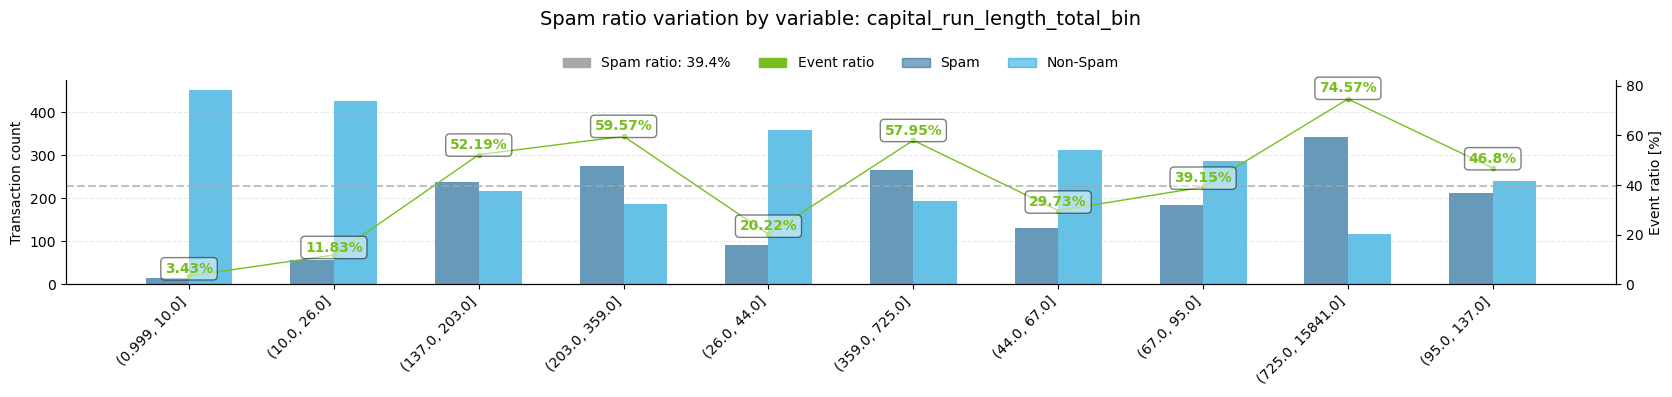

In [193]:
# Plotting the bivariate distribution
plot_bivariate_distribution(df=df, 
                            target_variable=spam, 
                            spam_ratio=tax_spam,
                            analysis_variable='capital_run_length_total_bin',
                            sort_values=False, #to ensure the bins are in order 
                            figsize=(20, 3),
                            #custom_xticks=custom_labels
                            )

In [176]:
num_bins = 5  # 5 bins to represent quartiles, can be changed to better interpret the data
df["char_freq_$_bin"] = pd.qcut(df['char_freq_$'], q=num_bins, duplicates='drop')

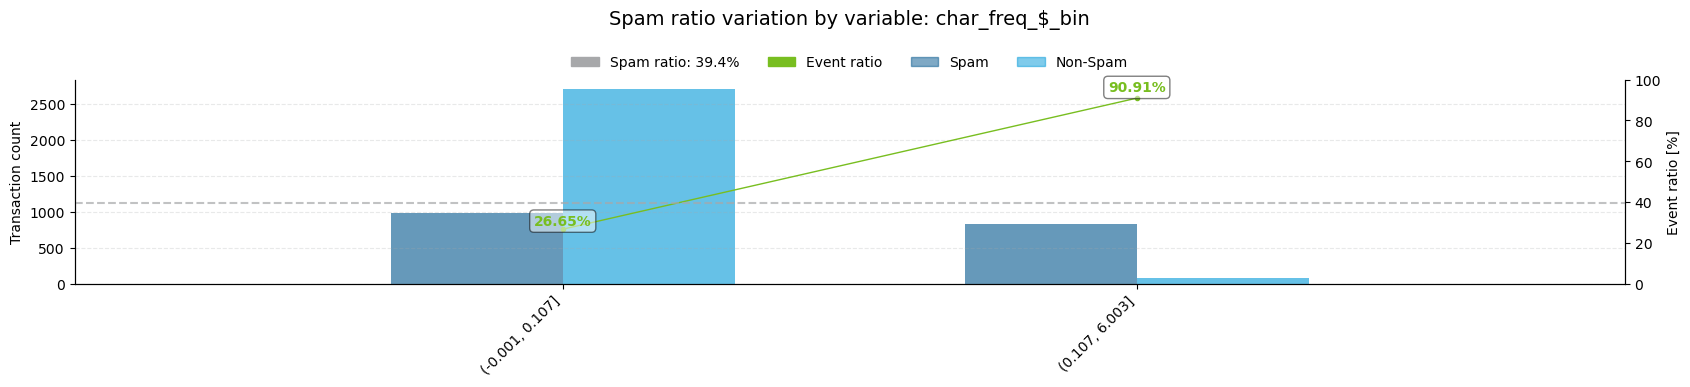

In [177]:
# Plotting the bivariate distribution
plot_bivariate_distribution(df=df, 
                            target_variable=spam, 
                            spam_ratio=tax_spam,
                            analysis_variable='char_freq_$_bin',
                            sort_values=False, #to ensure the bins are in order 
                            figsize=(20, 3),
                            #custom_xticks=custom_labels
                            )

In [180]:
num_bins = 5  # 5 bins to represent quartiles, can be changed to better interpret the data
df["word_freq_hp_bin"] = pd.qcut(df['word_freq_hp'], q=num_bins, duplicates='drop')

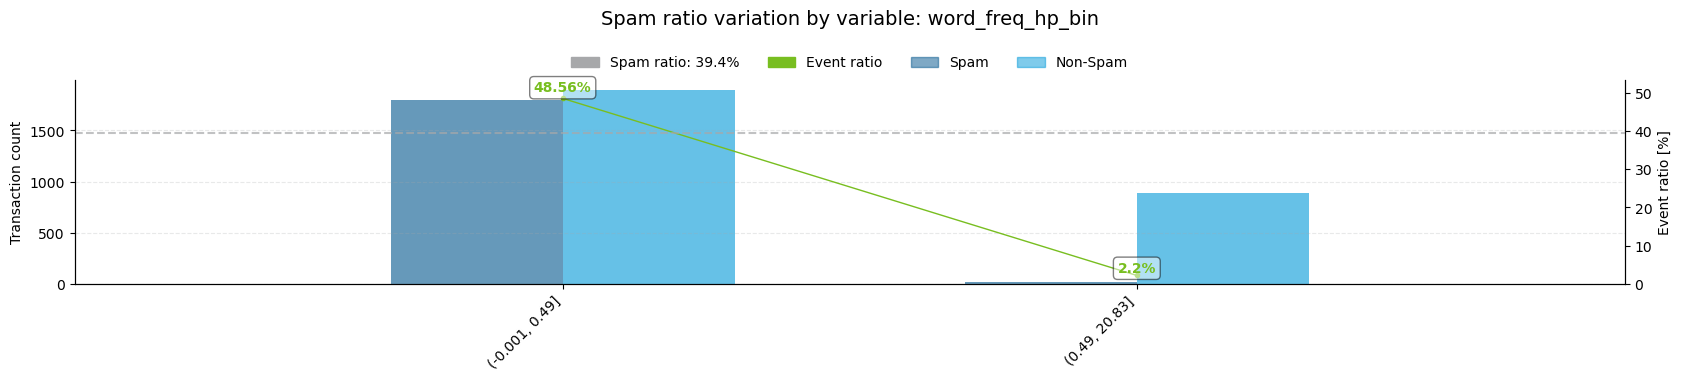

In [181]:
# Plotting the bivariate distribution
plot_bivariate_distribution(df=df, 
                            target_variable=spam, 
                            spam_ratio=tax_spam,
                            analysis_variable='word_freq_hp_bin',
                            sort_values=False, #to ensure the bins are in order 
                            figsize=(20, 3),
                            #custom_xticks=custom_labels
                            )

In [194]:
# Define specific columns to check
columns_to_check = ["char_freq_$", "word_freq_000", "word_freq_business", 
                    "capital_run_length_total", "word_freq_hp", "word_freq_money"]

# Check for NaN values in the specified columns
nan_counts = df[columns_to_check].isna().sum()

# Display the count of NaN values for each column
print(nan_counts)

char_freq_$                 0
word_freq_000               0
word_freq_business          0
capital_run_length_total    0
word_freq_hp                0
word_freq_money             0
dtype: int64



🔹 Avaliação - Modelo Base:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       531
           1       0.89      0.82      0.85       390

    accuracy                           0.88       921
   macro avg       0.88      0.87      0.88       921
weighted avg       0.88      0.88      0.88       921



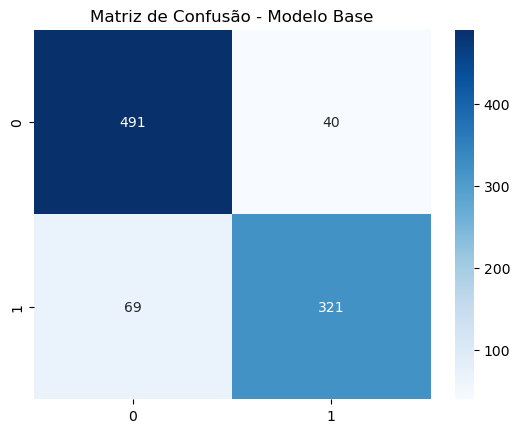


🔹 Avaliação - Conjunto de treino:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      2257
           1       0.99      0.94      0.96      1423

    accuracy                           0.97      3680
   macro avg       0.97      0.97      0.97      3680
weighted avg       0.97      0.97      0.97      3680



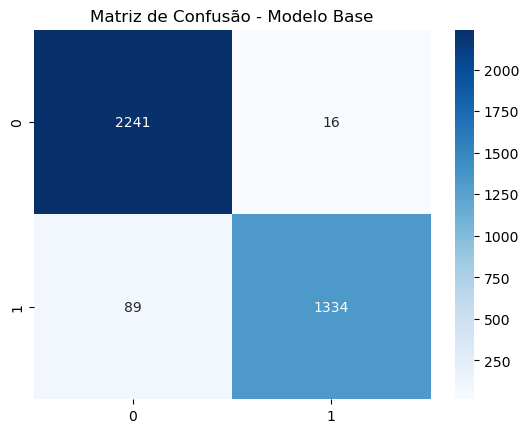

[I 2025-04-04 23:29:14,170] A new study created in memory with name: no-name-e86c42eb-d6a6-442f-a034-931e6d48389d
[I 2025-04-04 23:29:15,550] Trial 0 finished with value: 0.8707926167209555 and parameters: {'n_estimators': 258, 'max_depth': 17, 'min_samples_split': 11, 'min_samples_leaf': 19, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 0.8707926167209555.
[I 2025-04-04 23:29:17,061] Trial 1 finished with value: 0.8773072747014115 and parameters: {'n_estimators': 292, 'max_depth': 13, 'min_samples_split': 14, 'min_samples_leaf': 14, 'max_features': 'log2', 'bootstrap': False}. Best is trial 1 with value: 0.8773072747014115.
[I 2025-04-04 23:29:17,746] Trial 2 finished with value: 0.8327904451682954 and parameters: {'n_estimators': 273, 'max_depth': 4, 'min_samples_split': 11, 'min_samples_leaf': 19, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 0.8773072747014115.
[I 2025-04-04 23:29:18,015] Trial 3 finished with value: 0.8751357220

[I 2025-04-04 23:29:45,093] Trial 30 finished with value: 0.8740499457111836 and parameters: {'n_estimators': 179, 'max_depth': 18, 'min_samples_split': 12, 'min_samples_leaf': 20, 'max_features': 'log2', 'bootstrap': False}. Best is trial 15 with value: 0.8805646036916395.
[I 2025-04-04 23:29:46,372] Trial 31 finished with value: 0.8783930510314875 and parameters: {'n_estimators': 243, 'max_depth': 9, 'min_samples_split': 13, 'min_samples_leaf': 10, 'max_features': 'log2', 'bootstrap': False}. Best is trial 15 with value: 0.8805646036916395.
[I 2025-04-04 23:29:47,905] Trial 32 finished with value: 0.8805646036916395 and parameters: {'n_estimators': 280, 'max_depth': 14, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 'log2', 'bootstrap': False}. Best is trial 15 with value: 0.8805646036916395.
[I 2025-04-04 23:29:49,405] Trial 33 finished with value: 0.8773072747014115 and parameters: {'n_estimators': 279, 'max_depth': 14, 'min_samples_split': 10, 'min_samples_leaf':


🔹 Avaliação - Modelo Otimizado:
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       531
           1       0.93      0.79      0.85       390

    accuracy                           0.88       921
   macro avg       0.89      0.87      0.88       921
weighted avg       0.89      0.88      0.88       921



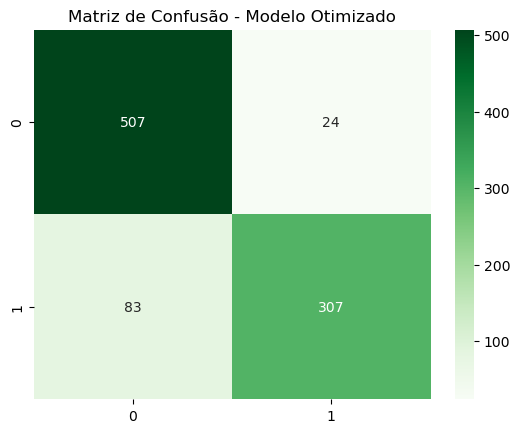


🔍 Média da variável 'word_freq_hp' nos falsos positivos:
0.012083333333333333


In [234]:
# 1. Variáveis
features = ['word_freq_your', 'word_freq_000', 'word_freq_credit', 
            'word_freq_money', 'word_freq_business', 'capital_run_length_total', 
            'char_freq_$', 'word_freq_hp']
target = 'is_spam'

# 2. Dividir os dados
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Modelo base
rf_base = RandomForestClassifier(random_state=42)
rf_base.fit(X_train, y_train)
y_pred_base = rf_base.predict(X_test)

# 4. Avaliação base
print("\n🔹 Avaliação - Modelo Base:")
print(classification_report(y_test, y_pred_base))
sns.heatmap(confusion_matrix(y_test, y_pred_base), annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão - Modelo Base')
plt.show()

y_pred_train_base = rf.predict(X_train)

# 4.1. Avaliacao treino 
print("\n🔹 Avaliação - Conjunto de treino:")
print(classification_report(y_train, y_pred_train_base))
sns.heatmap(confusion_matrix(y_train, y_pred_train_base), annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão - Modelo Base')
plt.show()

# 4.2.

# 5. Otimização com Optuna
def objective(trial):
    try:
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 20),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
            'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        }
        model = RandomForestClassifier(random_state=42, **params)
        model.fit(X_train, y_train)
        return model.score(X_test, y_test)
    except Exception as e:
        print(f"erro na tentativa: {e}")
        # Invalida a tentativa
        return float('nan')

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# 6. Modelo otimizado
rf_opt = RandomForestClassifier(random_state=42, **study.best_params)
rf_opt.fit(X_train, y_train)
y_pred_opt = rf_opt.predict(X_test)

# 7. Avaliação otimizada
print("\n🔹 Avaliação - Modelo Otimizado:")
print(classification_report(y_test, y_pred_opt))
sns.heatmap(confusion_matrix(y_test, y_pred_opt), annot=True, fmt='d', cmap='Greens')
plt.title('Matriz de Confusão - Modelo Otimizado')
plt.show()

# 8. Extra: Verificando os falsos positivos e a variável word_freq_hp
false_positives = (y_test == 0) & (y_pred_opt == 1)
print("\n🔍 Média da variável 'word_freq_hp' nos falsos positivos:")
print(X_test.loc[false_positives, 'word_freq_hp'].mean())

In [235]:
modelos = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'LightGBM': lgb.LGBMClassifier(random_state=42),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Regressão Logística': LogisticRegression(max_iter=1000, random_state=42)
}

# 4. Treinar, testar e avaliar todos os modelos
for nome, modelo in modelos.items():
    print(f"\n🔹 Modelo: {nome}")
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    # Relatório de métricas
    print(classification_report(y_test, y_pred))


    # Análise dos falsos positivos
    false_positives = (y_test == 0) & (y_pred == 1)
    media_hp = X_test.loc[false_positives, 'word_freq_hp'].mean()
    print(f"🔍 Média de 'word_freq_hp' nos falsos positivos: {media_hp:.4f}")


🔹 Modelo: Random Forest
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       531
           1       0.89      0.82      0.85       390

    accuracy                           0.88       921
   macro avg       0.88      0.87      0.88       921
weighted avg       0.88      0.88      0.88       921

🔍 Média de 'word_freq_hp' nos falsos positivos: 0.0072

🔹 Modelo: LightGBM
[LightGBM] [Info] Number of positive: 1423, number of negative: 2257
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1394
[LightGBM] [Info] Number of data points in the train set: 3680, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.386685 -> initscore=-0.461269
[LightGBM] [Info] Start training from score -0.461269
              preci


🔹 Avaliação - Modelo Regularizado (Teste):
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       531
           1       0.92      0.77      0.84       390

    accuracy                           0.87       921
   macro avg       0.88      0.86      0.87       921
weighted avg       0.88      0.87      0.87       921



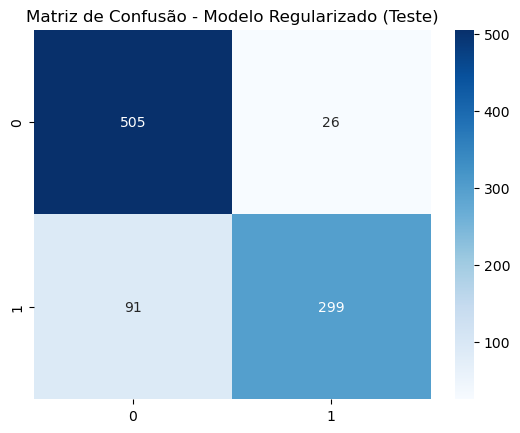


🔹 Avaliação - Modelo Regularizado (Treino):
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2257
           1       0.92      0.80      0.86      1423

    accuracy                           0.90      3680
   macro avg       0.90      0.88      0.89      3680
weighted avg       0.90      0.90      0.89      3680



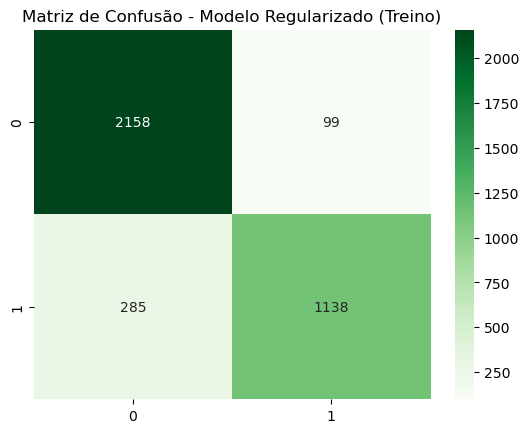

In [236]:
# 1. Modelo Regularizado
rf_regularizado = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    bootstrap=True,
    random_state=42
)

# 2. Treinamento
rf_regularizado.fit(X_train, y_train)

# 3. Avaliação no conjunto de teste
y_pred_test_reg = rf_regularizado.predict(X_test)
print("\n🔹 Avaliação - Modelo Regularizado (Teste):")
print(classification_report(y_test, y_pred_test_reg))

sns.heatmap(confusion_matrix(y_test, y_pred_test_reg), annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão - Modelo Regularizado (Teste)')
plt.show()

# 4. Avaliação no conjunto de treino
y_pred_train_reg = rf_regularizado.predict(X_train)
print("\n🔹 Avaliação - Modelo Regularizado (Treino):")
print(classification_report(y_train, y_pred_train_reg))

sns.heatmap(confusion_matrix(y_train, y_pred_train_reg), annot=True, fmt='d', cmap='Greens')
plt.title('Matriz de Confusão - Modelo Regularizado (Treino)')
plt.show()

In [238]:
# 1. Definir o modelo regularizado
rf_cv = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    bootstrap=True,
    random_state=42
)

# 2. Cross-validation estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 3. Avaliação com F1 da classe 1 (spam)
f1_scores = cross_val_score(rf_cv, X, y, cv=cv, scoring='f1')
print("🔁 F1-Score por Fold:", f1_scores)
print(f"📊 Média do F1-Score: {f1_scores.mean():.4f}")
print(f"📉 Desvio padrão: {f1_scores.std():.4f}")

🔁 F1-Score por Fold: [0.82666667 0.84795322 0.84411765 0.8563135  0.85081241]
📊 Média do F1-Score: 0.8452
📉 Desvio padrão: 0.0101


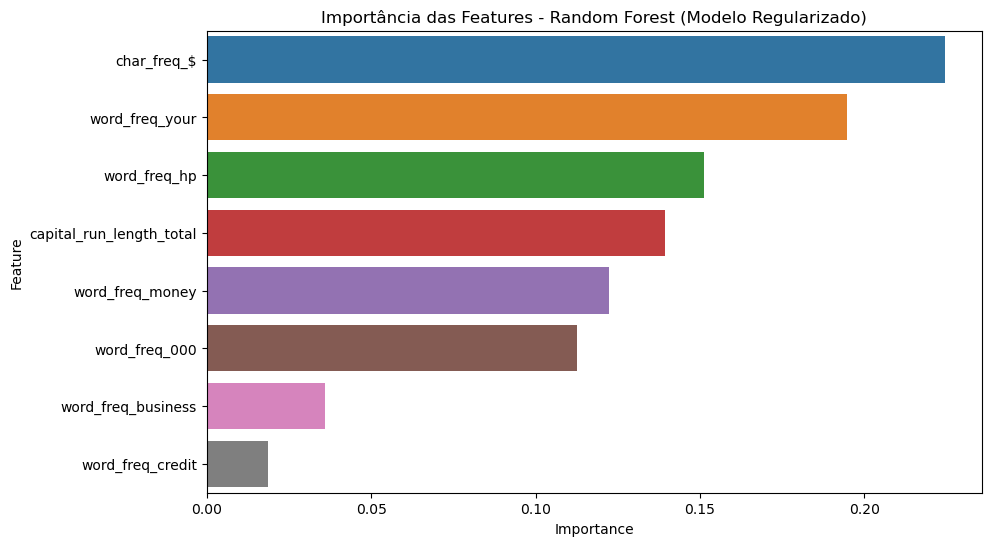

🔹 5 principais features:
                    Feature  Importance
6               char_freq_$    0.224499
0            word_freq_your    0.194812
7              word_freq_hp    0.151360
5  capital_run_length_total    0.139503
3           word_freq_money    0.122409


In [240]:
# 1. Definir o modelo regularizado
rf_cv = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    bootstrap=True,
    random_state=42
)

# 2. Treinar o modelo
rf_cv.fit(X_train, y_train)

# 3. Obter a importância das features
importances = rf_cv.feature_importances_

# 4. Criar DataFrame com as importâncias
feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# 5. Ordenar por importância
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# 6. Plotar gráfico
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Importância das Features - Random Forest (Modelo Regularizado)')
plt.show()

# 7. Exibir as 5 principais features
print("🔹 5 principais features:")
print(feature_importances.head())

📊 Avaliação com Threshold 0.3:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       531
           1       0.84      0.86      0.85       390

    accuracy                           0.87       921
   macro avg       0.87      0.87      0.87       921
weighted avg       0.87      0.87      0.87       921



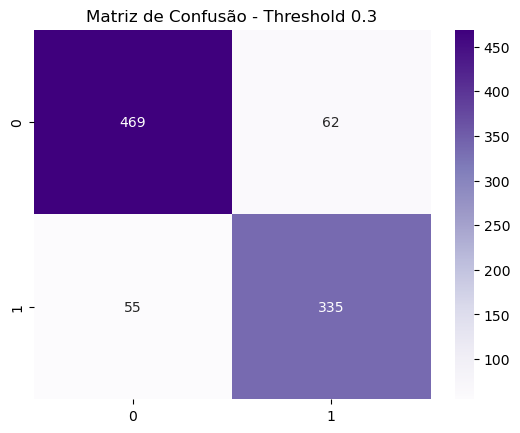

In [241]:
# 1. Previsões de probabilidade do modelo
y_pred_prob = rf_cv.predict_proba(X_test)[:, 1]  # Probabilidade de ser spam (classe 1)

# 2. Ajustar o threshold (aqui estamos usando 0.3, mas pode testar outros valores)
threshold = 0.3
y_pred_adjusted = (y_pred_prob > threshold).astype(int)

# 3. Avaliar os resultados com o novo threshold
print(f"📊 Avaliação com Threshold {threshold}:")
print(classification_report(y_test, y_pred_adjusted))

# 4. Matriz de confusão com o novo threshold
sns.heatmap(confusion_matrix(y_test, y_pred_adjusted), annot=True, fmt='d', cmap='Purples')
plt.title(f'Matriz de Confusão - Threshold {threshold}')
plt.show()

In [244]:
import lightgbm as lgb
import optuna
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# 1. Variáveis
features = ['word_freq_your', 'word_freq_000', 'word_freq_credit', 
            'word_freq_money', 'word_freq_business', 'capital_run_length_total', 
            'char_freq_$', 'word_freq_hp']
target = 'is_spam'

# 2. Dividir os dados
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Modelo base - LightGBM
lgb_base = lgb.LGBMClassifier(random_state=42)
lgb_base.fit(X_train, y_train)
y_pred_base = lgb_base.predict(X_test)

# 4. Avaliação base
print("\n🔹 Avaliação - Modelo Base (LightGBM):")
print(classification_report(y_test, y_pred_base))


y_pred_train_base = lgb_base.predict(X_train)

# 4.1. Avaliação treino 
print("\n🔹 Avaliação - Conjunto de treino (LightGBM):")
print(classification_report(y_train, y_pred_train_base))


# 5. Otimização com Optuna
def objective(trial):
    try:
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 20),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
            'num_leaves': trial.suggest_int('num_leaves', 20, 100),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
            'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
            'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        }
        model = lgb.LGBMClassifier(random_state=42, **params)
        model.fit(X_train, y_train)
        return model.score(X_test, y_test)
    except Exception as e:
        print(f"Erro na tentativa: {e}")
        # Invalida a tentativa
        return float('nan')

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# 6. Modelo otimizado - LightGBM
lgb_opt = lgb.LGBMClassifier(random_state=42, **study.best_params)
lgb_opt.fit(X_train, y_train)
y_pred_opt = lgb_opt.predict(X_test)

# 7. Avaliação otimizada
print("\n🔹 Avaliação - Modelo Otimizado (LightGBM):")
print(classification_report(y_test, y_pred_opt))


# 8. Extra: Verificando os falsos positivos e a variável word_freq_hp
false_positives = (y_test == 0) & (y_pred_opt == 1)
print("\n🔍 Média da variável 'word_freq_hp' nos falsos positivos:")
print(X_test.loc[false_positives, 'word_freq_hp'].mean())


[I 2025-04-05 00:51:16,015] A new study created in memory with name: no-name-fcf03572-58c0-4af4-b92b-c34effdeecc3
C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:45: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:46: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/rel

[LightGBM] [Info] Number of positive: 1423, number of negative: 2257
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1394
[LightGBM] [Info] Number of data points in the train set: 3680, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.386685 -> initscore=-0.461269
[LightGBM] [Info] Start training from score -0.461269

🔹 Avaliação - Modelo Base (LightGBM):
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       531
           1       0.92      0.78      0.85       390

    accuracy                           0.88       921
   macro avg       0.89      0.87      0.87       921
weighted avg       0.88      0.88      0.88       921


🔹 Avaliação - Conjunto de treino (LightGBM):
              precision    recall 

C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:45: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:46: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 

[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] feature_fraction is set=0.916345271092485, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.916345271092485
[LightGBM] [Warning] bagging_fraction is set=0.9819453920891702, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9819453920891702
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] feature_fraction is set=0.916345271092485, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.916345271092485
[LightGBM] [Warning] bagging_fraction is set=0.9819453920891702, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9819453920891702
[LightGBM] [Warning] bagging_freq is set=3, subsam

C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:45: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:46: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:45: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:46: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.9627048771149419, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9627048771149419
[LightGBM] [Warning] bagging_fraction is set=0.9716710369497541, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9716710369497541
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.9627048771149419, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9627048771149419
[LightGBM] [Warning] bagging_fraction is set=0.9716710369497541, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9716710369497541
[LightGBM] [Warning] bagging_freq is set=7

C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:45: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:46: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 

[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] feature_fraction is set=0.7891119484962087, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7891119484962087
[LightGBM] [Warning] bagging_fraction is set=0.7538633680253757, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7538633680253757
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] feature_fraction is set=0.7891119484962087, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7891119484962087
[LightGBM] [Warning] bagging_fraction is set=0.7538633680253757, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7538633680253757
[LightGBM] [Warning] bagging_freq is set=4, su

C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:45: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:46: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 

[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] feature_fraction is set=0.6290507669921998, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6290507669921998
[LightGBM] [Warning] bagging_fraction is set=0.6381232098687097, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6381232098687097
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] feature_fraction is set=0.6290507669921998, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6290507669921998
[LightGBM] [Warning] bagging_fraction is set=0.6381232098687097, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6381232098687097
[LightGBM] [Warning] bagging_freq is set=2, su

[I 2025-04-05 00:51:17,222] Trial 12 finished with value: 0.8827361563517915 and parameters: {'n_estimators': 287, 'max_depth': 3, 'learning_rate': 0.046660212276057725, 'num_leaves': 36, 'min_data_in_leaf': 41, 'feature_fraction': 0.6012447230823541, 'bagging_fraction': 0.8403181084679685, 'bagging_freq': 2}. Best is trial 12 with value: 0.8827361563517915.
C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:45: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_un

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:45: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:46: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:45: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:46: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 

[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] feature_fraction is set=0.6009215855268565, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6009215855268565
[LightGBM] [Warning] bagging_fraction is set=0.8299921325518139, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8299921325518139
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] feature_fraction is set=0.6009215855268565, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6009215855268565
[LightGBM] [Warning] bagging_fraction is set=0.8299921325518139, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8299921325518139
[LightGBM] [Warning] bagging_freq is set=2, su

[I 2025-04-05 00:51:17,842] Trial 17 finished with value: 0.8794788273615635 and parameters: {'n_estimators': 299, 'max_depth': 4, 'learning_rate': 0.05334560090239688, 'num_leaves': 72, 'min_data_in_leaf': 10, 'feature_fraction': 0.862886671838863, 'bagging_fraction': 0.7726565029329617, 'bagging_freq': 4}. Best is trial 12 with value: 0.8827361563517915.
C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:45: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_unif

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:45: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:46: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 

[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] feature_fraction is set=0.6919876688593178, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6919876688593178
[LightGBM] [Warning] bagging_fraction is set=0.7224285953958565, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7224285953958565
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] feature_fraction is set=0.6919876688593178, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6919876688593178
[LightGBM] [Warning] bagging_fraction is set=0.7224285953958565, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7224285953958565
[LightGBM] [Warning] bagging_freq is set=3, su

C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:45: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:46: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 

[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] feature_fraction is set=0.6626054020856297, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6626054020856297
[LightGBM] [Warning] bagging_fraction is set=0.721444328392814, subsample=1.0 will be ignored. Current value: bagging_fraction=0.721444328392814
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] feature_fraction is set=0.6626054020856297, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6626054020856297
[LightGBM] [Warning] bagging_fraction is set=0.721444328392814, subsample=1.0 will be ignored. Current value: bagging_fraction=0.721444328392814
[LightGBM] [Warning] bagging_freq is set=3, subsam

C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:45: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:46: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 

[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] feature_fraction is set=0.6304507610140517, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6304507610140517
[LightGBM] [Warning] bagging_fraction is set=0.7224975101645613, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7224975101645613
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] feature_fraction is set=0.6304507610140517, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6304507610140517
[LightGBM] [Warning] bagging_fraction is set=0.7224975101645613, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7224975101645613
[LightGBM] [Warning] bagging_freq is set=3, su

[I 2025-04-05 00:51:18,817] Trial 24 finished with value: 0.8783930510314875 and parameters: {'n_estimators': 275, 'max_depth': 8, 'learning_rate': 0.04245330631133656, 'num_leaves': 55, 'min_data_in_leaf': 30, 'feature_fraction': 0.6002514206133659, 'bagging_fraction': 0.7903150878189307, 'bagging_freq': 1}. Best is trial 12 with value: 0.8827361563517915.
C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:45: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uni

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:45: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:46: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 

[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] feature_fraction is set=0.7200594782531463, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7200594782531463
[LightGBM] [Warning] bagging_fraction is set=0.6796806603983445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6796806603983445
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] feature_fraction is set=0.7200594782531463, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7200594782531463
[LightGBM] [Warning] bagging_fraction is set=0.6796806603983445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6796806603983445
[LightGBM] [Warning] bagging_freq is set=4, su

[I 2025-04-05 00:51:19,215] Trial 27 finished with value: 0.8762214983713354 and parameters: {'n_estimators': 285, 'max_depth': 7, 'learning_rate': 0.07042624398229456, 'num_leaves': 76, 'min_data_in_leaf': 64, 'feature_fraction': 0.6347863470839419, 'bagging_fraction': 0.8999397598440209, 'bagging_freq': 3}. Best is trial 12 with value: 0.8827361563517915.
C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:45: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uni

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:46: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
[I 2025-04-05 00:51:19,449] Trial 28 finished with value: 0.8751357220412594 and parameters: {'n_estimators': 253, 'max_depth': 13, 'learning_rate': 0.04521691065397804, 'num_leaves': 57, 'min_data_in_leaf': 35, 'feature_fraction': 0.6516879437292283, 'bagging_fraction': 0.7524820686639837, 'bagging_freq': 2}. Best is trial 12 with value: 0.8827361563517915.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:45: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:46: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:45: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:46: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 

[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] feature_fraction is set=0.6317820270830943, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6317820270830943
[LightGBM] [Warning] bagging_fraction is set=0.8381368994670292, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8381368994670292
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] feature_fraction is set=0.6317820270830943, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6317820270830943
[LightGBM] [Warning] bagging_fraction is set=0.8381368994670292, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8381368994670292
[LightGBM] [Warning] bagging_freq is set=1, su

C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:45: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:46: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 

[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] feature_fraction is set=0.6728657575348862, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6728657575348862
[LightGBM] [Warning] bagging_fraction is set=0.9203089972334975, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9203089972334975
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] feature_fraction is set=0.6728657575348862, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6728657575348862
[LightGBM] [Warning] bagging_fraction is set=0.9203089972334975, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9203089972334975
[LightGBM] [Warning] bagging_freq is set=1, su

[I 2025-04-05 00:51:20,352] Trial 34 finished with value: 0.8805646036916395 and parameters: {'n_estimators': 281, 'max_depth': 8, 'learning_rate': 0.04038632697646842, 'num_leaves': 32, 'min_data_in_leaf': 57, 'feature_fraction': 0.6197302156953689, 'bagging_fraction': 0.9345365303789299, 'bagging_freq': 1}. Best is trial 32 with value: 0.8849077090119435.
C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:45: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uni

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:46: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
[I 2025-04-05 00:51:20,520] Trial 35 finished with value: 0.8805646036916395 and parameters: {'n_estimators': 284, 'max_depth': 6, 'learning_rate': 0.043302385676875256, 'num_leaves': 24, 'min_data_in_leaf': 16, 'feature_fraction': 0.671086237044997, 'bagging_fraction': 0.8989659609128596, 'bagging_freq': 1}. Best is trial 32 with value: 0.8849077090119435.
C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_logu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:45: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:46: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:45: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:46: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:46: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
[I 2025-04-05 00:51:21,381] Trial 39 finished with value: 0.8816503800217155 and parameters: {'n_estimators': 250, 'max_depth': 11, 'learning_rate': 0.01921090221128087, 'num_leaves': 94, 'min_data_in_leaf': 14, 'feature_fraction': 0.736873351527067, 'bagging_fraction': 0.9345443843589624, 'bagging_freq': 7}. Best is trial 38 with value: 0.8859934853420195.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:45: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:46: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 

[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] feature_fraction is set=0.8266864800859539, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8266864800859539
[LightGBM] [Warning] bagging_fraction is set=0.9148563868114403, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9148563868114403
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] feature_fraction is set=0.8266864800859539, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8266864800859539
[LightGBM] [Warning] bagging_fraction is set=0.9148563868114403, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9148563868114403
[LightGBM] [Warning] bagging_freq is set=1, su

[I 2025-04-05 00:51:21,657] Trial 40 finished with value: 0.8762214983713354 and parameters: {'n_estimators': 198, 'max_depth': 20, 'learning_rate': 0.02385092788816367, 'num_leaves': 98, 'min_data_in_leaf': 24, 'feature_fraction': 0.8266864800859539, 'bagging_fraction': 0.9148563868114403, 'bagging_freq': 1}. Best is trial 38 with value: 0.8859934853420195.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] feature_fraction is set=0.8266864800859539, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8266864800859539
[LightGBM] [Warning] bagging_fraction is set=0.91

C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:45: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:46: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 

[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] feature_fraction is set=0.6742016282589177, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6742016282589177
[LightGBM] [Warning] bagging_fraction is set=0.9605579215704328, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9605579215704328
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=62
[LightGBM] [Warning] feature_fraction is set=0.71170693721453, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.71170693721453
[LightGBM] [Warning] bagging_fraction is set=0.963924356361426, subsample=1.0 will be ignored. Current value: bagging_fraction=0.963924356361426
[LightGBM] [Warning] bagging_freq is set=2, subsampl

C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:45: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:46: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
[I 2025-04-05 00:51:22,028] Trial 42 finished with value: 0.8794788273615635 and parameters: {'n_estimators': 274, 'max_depth': 9, 'learning_rate': 0.035576767891774407, 'num_leaves': 86, 'min_data_in_leaf': 62, 'feature_fraction': 0.71170693721453, 'bagging_fraction': 0.963924356361426, 'bagging_freq': 2}. Best is trial 38 with value: 0.

[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] feature_fraction is set=0.7629358092298969, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7629358092298969
[LightGBM] [Warning] bagging_fraction is set=0.9511082977409775, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9511082977409775
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] feature_fraction is set=0.7629358092298969, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7629358092298969
[LightGBM] [Warning] bagging_fraction is set=0.9511082977409775, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9511082977409775
[LightGBM] [Warning] bagging_freq is set=6, su

[I 2025-04-05 00:51:22,284] Trial 44 finished with value: 0.8870792616720955 and parameters: {'n_estimators': 91, 'max_depth': 8, 'learning_rate': 0.03807785042927808, 'num_leaves': 99, 'min_data_in_leaf': 21, 'feature_fraction': 0.6784969322678721, 'bagging_fraction': 0.9782184719508488, 'bagging_freq': 2}. Best is trial 44 with value: 0.8870792616720955.
C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:45: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_unif

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:45: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:46: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 

[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.6815500322760067, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6815500322760067
[LightGBM] [Warning] bagging_fraction is set=0.9489272112429801, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9489272112429801
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.6815500322760067, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6815500322760067
[LightGBM] [Warning] bagging_fraction is set=0.9489272112429801, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9489272112429801
[LightGBM] [Warning] bagging_freq is set=2, su

C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:45: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:46: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 

[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] feature_fraction is set=0.7133429993093591, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7133429993093591
[LightGBM] [Warning] bagging_fraction is set=0.9769879378973974, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9769879378973974
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] feature_fraction is set=0.7133429993093591, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7133429993093591
[LightGBM] [Warning] bagging_fraction is set=0.9769879378973974, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9769879378973974
[LightGBM] [Warning] bagging_freq is set=1, su

[I 2025-04-05 00:51:22,916] Trial 48 finished with value: 0.8230184581976113 and parameters: {'n_estimators': 58, 'max_depth': 17, 'learning_rate': 0.012808605702199629, 'num_leaves': 94, 'min_data_in_leaf': 54, 'feature_fraction': 0.6476706172015991, 'bagging_fraction': 0.914821292568457, 'bagging_freq': 2}. Best is trial 44 with value: 0.8870792616720955.
C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\erikg\AppData\Local\Temp\ipykernel_33976\3880646918.py:45: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uni

[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] feature_fraction is set=0.7320135067293534, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7320135067293534
[LightGBM] [Warning] bagging_fraction is set=0.887864793986996, subsample=1.0 will be ignored. Current value: bagging_fraction=0.887864793986996
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] feature_fraction is set=0.7320135067293534, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7320135067293534
[LightGBM] [Warning] bagging_fraction is set=0.887864793986996, subsample=1.0 will be ignored. Current value: bagging_fraction=0.887864793986996
[LightGBM] [Warning] bagging_freq is set=3, subsam